In [11]:
import re
from pathlib import Path
from collections import Counter
from lxml import etree
from tqdm.auto import tqdm
import zhon.hanzi
import pandas as pd

In [2]:
dyn_list = Path("../data/cbeta_dynasty.txt").read_text().strip().split("\n")
dyn_list = {dyn_x: year_x
            for dyn_x, year_x in map(lambda x: x.split(" "), dyn_list)}
dyn_year = {dyn_x: int(year_x.split("–")[0])  # split by an en-dash
            for dyn_x, year_x in dyn_list.items()}
list(dyn_year.items())[:5]

[('民國', 1911), ('清', 1636), ('明', 1368), ('元', 1271), ('金', 1115)]

In [3]:
cjk_pat = re.compile(f"[{zhon.hanzi.characters}]")
def count_target(re_pat, text):
    return sum(1 for _ in re_pat.finditer(text))

def count_character(text):
    return sum(1 for _ in cjk_pat.finditer(text))

def count_char_dict(text):
    return Counter(cjk_pat.findall(text))

def get_dynasty(author_field):
    tok = author_field.split()
    if tok and (tok[0] in dyn_list):
        return tok[0]
    else:
        return None

In [4]:
xml_dir = Path("../corpus/Bookcase/CBETA/XML/")
xml_paths = list(xml_dir.glob("**/*.xml"))
authors = []

tree = etree.parse(xml_paths[0])
root = tree.getroot()
nsmap = root.nsmap
nsmap.pop(None)
nsmap = {"tei": "http://www.tei-c.org/ns/1.0", **nsmap}

In [5]:

def make_dyn_charfreq():
    dyn_counter = {dyn_x: Counter() for dyn_x in dyn_list.keys()}

    for path_x in tqdm(xml_paths):
        tree = etree.parse(path_x)
        root = tree.getroot() 
        author_elems = root.xpath("//tei:author", namespaces=nsmap)
        text_elems = root.xpath("//tei:text", namespaces=nsmap)
        assert len(text_elems)==1
        if author_elems:            
            author_text = ''.join(author_elems[0].itertext())    
            dyn_x = get_dynasty(author_text)
            if dyn_x is None: continue
            fulltext = ''.join(text_elems[0].itertext())
            char_dict = count_char_dict(fulltext)
            dyn_counter[dyn_x].update(char_dict)
    return dyn_counter

In [6]:
dyn_char_freq = make_dyn_charfreq()

  0%|          | 0/21648 [00:00<?, ?it/s]

In [13]:
char_freq_df = pd.DataFrame(dict(
            ntoken=[sum(x.values()) for x in dyn_char_freq.values()],
            ntype=[len(x) for x in dyn_char_freq.values()]),
        index=dyn_char_freq.keys())

In [15]:
char_freq_df.to_csv("../data/cbeta.char_freq_stat.csv")

## EDAs

In [8]:
def make_dyn_textsize():
    dyn_textsize = {dyn_x: 0 for dyn_x in dyn_list.keys()}

    for path_x in tqdm(xml_paths):
        tree = etree.parse(path_x)
        root = tree.getroot() 
        author_elems = root.xpath("//tei:author", namespaces=nsmap)
        text_elems = root.xpath("//tei:text", namespaces=nsmap)
        assert len(text_elems)==1
        if author_elems:
            author_text = ''.join(author_elems[0].itertext())    
            dyn_x = get_dynasty(author_text)
            if dyn_x is None: continue
            fulltext = ''.join(text_elems[0].itertext())
            charcount = count_character(fulltext)
            dyn_textsize[dyn_x] += charcount
    return dyn_textsize

In [6]:
def make_dyn_freq(target_pat):
    dyn_freq = {dyn_x: 0 for dyn_x in dyn_list.keys()}
    dyn_textsize = {dyn_x: 0 for dyn_x in dyn_list.keys()}

    for path_x in tqdm(xml_paths):
        tree = etree.parse(path_x)
        root = tree.getroot() 
        author_elems = root.xpath("//tei:author", namespaces=nsmap)
        text_elems = root.xpath("//tei:text", namespaces=nsmap)
        assert len(text_elems)==1
        if author_elems:
            author_text = ''.join(author_elems[0].itertext())    
            dyn_x = get_dynasty(author_text)
            if dyn_x is None: continue
            fulltext = ''.join(text_elems[0].itertext())
            freq = count_target(target_pat, fulltext)
            dyn_freq[dyn_x] += freq   
    return dyn_freq

In [9]:
dyn_textsize = make_dyn_textsize()

  0%|          | 0/21648 [00:00<?, ?it/s]

In [12]:
target_pat = re.compile("眼")
dyn_freq = make_dyn_freq(target_pat)

  0%|          | 0/21648 [00:00<?, ?it/s]

In [15]:
dyn_year

{'民國': 1911,
 '清': 1636,
 '明': 1368,
 '元': 1271,
 '金': 1115,
 '宋': 960,
 '遼': 960,
 '後漢': 947,
 '吳': 907,
 '唐': 618,
 '隋': 581,
 '陳': 557,
 '北周': 557,
 '梁': 555,
 '蕭齊': 479,
 '劉宋': 420,
 '北涼': 397,
 '元魏': 386,
 '後魏': 386,
 '姚秦': 384,
 '後秦': 384,
 '符秦': 350,
 '東晉': 317,
 '西晉': 266,
 '曹魏': 220,
 '新羅': -57}

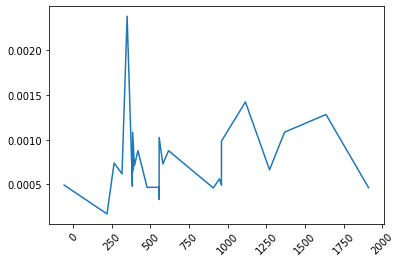

In [13]:
import matplotlib.pyplot as plt
ratio_by_dyn = [dyn_freq[dyn_x]/dyn_textsize[dyn_x] 
                for dyn_x in dyn_list.keys()]
plt.plot([dyn_year[x] for x in dyn_list.keys()], ratio_by_dyn)
_ = plt.xticks(rotation=45)

In [17]:
import pandas as pd

In [24]:
dyn_df = pd.DataFrame(    
            dict(year=dyn_year.values(),
                 target=dyn_freq.values(), 
                 nchar=dyn_textsize.values()), 
        index=dyn_freq.keys())

The intervals are defined ad-hoc. It is just for easier EDA
```
[-57, 317)      東晉之前
[317, 581)      東晉到隋之前
[581, 618)      隋
[618, 960)      唐、五代十國
[960, 1271)     宋
[1271, 1636)    元、明、清
```

In [59]:
dyn_spans = [
    -57,317,581,618,960,1271,1636
]
span_df = dyn_df\
    .groupby(pd.cut(dyn_df.year, dyn_spans, right=False))\
    .apply(lambda df_x: df_x.target.sum()/df_x.nchar.sum())

In [60]:
span_df

year
[-57, 317)      0.000662
[317, 581)      0.000739
[581, 618)      0.000729
[618, 960)      0.000869
[960, 1271)     0.000977
[1271, 1636)    0.001032
dtype: float64

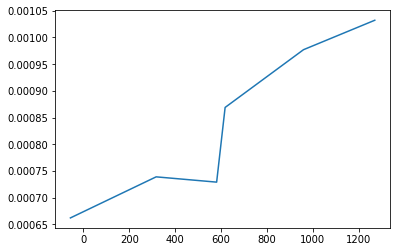

In [61]:
plt.plot([x.left for x in span_df.index], span_df.values)